In [20]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [21]:
!nvidia-smi
!nvcc --version

Tue Apr 15 03:59:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
%%writefile vector_add.cu

#include <stdio.h>

// Host: the CPU
// Device: The GPU
// Kernel: a function that runs on the GPU and is called from the CPU


// __global__ is use to define a kernel.
__global__ void AddTwoVectors(float A[], float B[], float C[]) {
    int i = threadIdx.x;    // Each thread is given a unique threadID
    C[i] = A[i] + B[i];
}

int main(){
    int N = 1000;
    float A[N], B[N], C[N];

    // Initialize vectors A and B
    for (int i = 0; i < N; i++) {
        A[i] = 1;
        B[i] = sinf(i * 0.1f);
    }


    float *d_A, *d_B, *d_C;     // Device pointers for vectors A, B, and C

    /*
    Note that in CUDA programming, you can't directly use host arrays (like A, B, and C) with kernel launches (<<< ... >>>).

    CUDA kernel operate on device memory, so you need to pass device pointers (d_A, d_B, and d_C) to the kernel for it to operate on.

    Beyond that, we need to allocate memory on the device by using cudaMalloc, and copy data between host and device using cudaMemcpy.
    */

    // Allocate memory on the device for vectors A, B, and C
    cudaMalloc((void **)&d_A, N * sizeof(float));
    cudaMalloc((void **)&d_B, N * sizeof(float));
    cudaMalloc((void **)&d_C, N * sizeof(float));


    // Copy vectors A and B from host to device
    cudaMemcpy(d_A, A, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N * sizeof(float), cudaMemcpyHostToDevice);


    // The number of CUDA threads that execute the above kernel can be spefified using <<< >>> notation.
    // Kernel invocation with N threads
    AddTwoVectors<<<1, N>>>(d_A, d_B, d_C);


    /*

    cudaDeviceSynchronize() is used to synchronize the device and the host thread.

    When this function is called, the host thread will wait until all previously issued CUDA commands on the device are completed before continuing execution.
    */


    // Check for errors in kernel launch (e.g. invalid configuration)
    cudaError_t error = cudaGetLastError();


    if(error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        exit(-1);
    }


    // Wait until all CUDA threads are executed
    cudaDeviceSynchronize();


    // copy vector C from device to host
    cudaMemcpy(C, d_C, N * sizeof(float), cudaMemcpyDeviceToHost);


    // Print the first 10 elements of C for verification
    printf("First 10 elements of C:\n");
    for (int i = 0; i < 10; i++) {
        printf("C[%d] = %f\n", i, C[i]);
    }

    // Save the entire C array to a file for plotting
    FILE *fp = fopen("vector_c.txt", "w");
    if (fp == NULL) {
        printf("Error opening file!\n");
        exit(-1);
    }
    for (int i = 0; i < N; i++) {
        fprintf(fp, "%f\n", C[i]);
    }
    fclose(fp);


    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}


Overwriting vector_add.cu


In [23]:
!nvcc vector_add.cu -o vector_add -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [24]:
!./vector_add

First 10 elements of C:
C[0] = 1.000000
C[1] = 1.099833
C[2] = 1.198669
C[3] = 1.295520
C[4] = 1.389418
C[5] = 1.479426
C[6] = 1.564642
C[7] = 1.644218
C[8] = 1.717356
C[9] = 1.783327


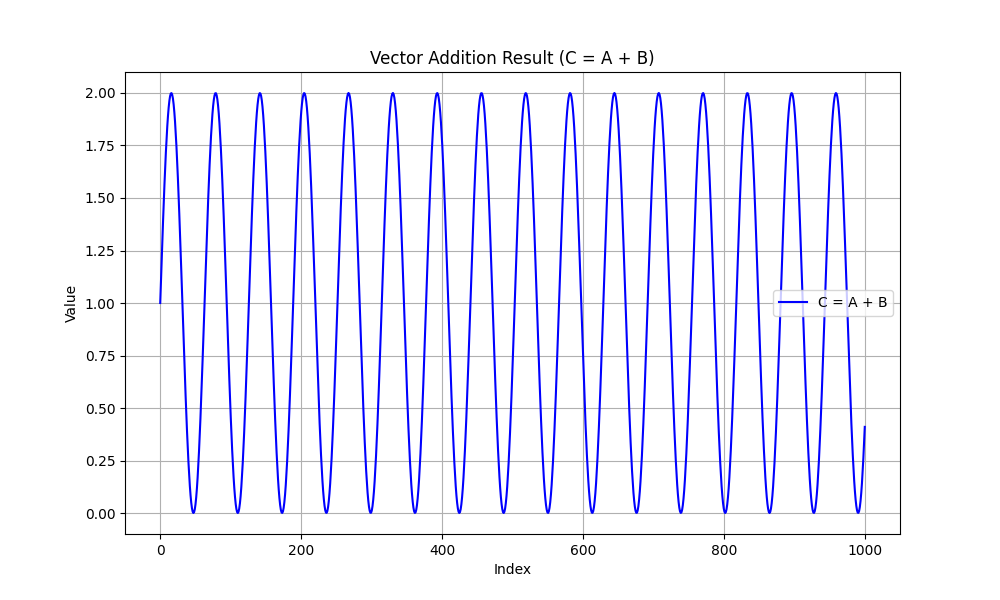

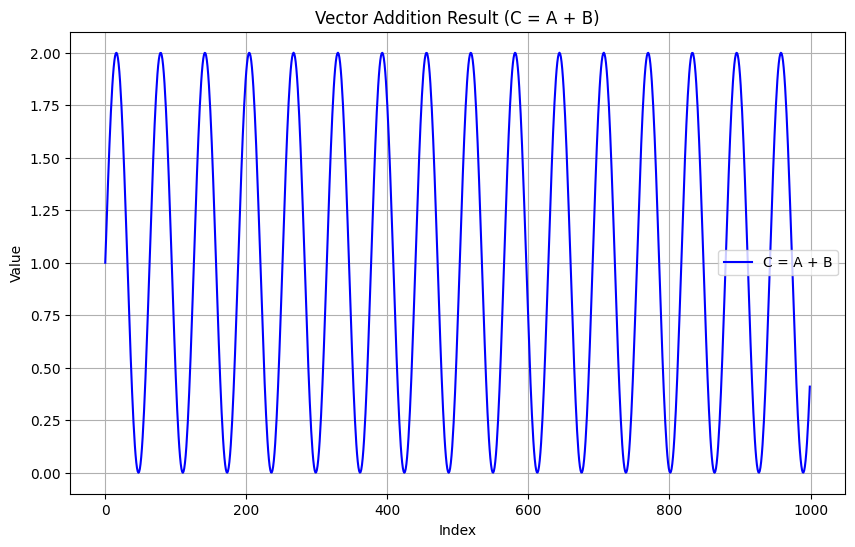

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the file
with open("vector_c.txt", "r") as f:
    C = [float(line.strip()) for line in f]

# Create an index array for the x-axis (0 to 999)
x = np.arange(len(C))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, C, label='C = A + B', color='blue')
plt.title('Vector Addition Result (C = A + B)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Save the plot to a file (since plt.show() isn't used in Colab as per guidelines)
plt.savefig('vector_add_plot.png')

# Display the plot in Colab (optional, for user to see immediately)
from IPython.display import Image
Image('vector_add_plot.png')